# VAE

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import mnist

(train_X, _), (valid_X, _) = mnist.load_data() # Your Dataset

train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype("float32") / 255
valid_X = valid_X.reshape(valid_X.shape[0], 28, 28, 1).astype("float32") /  255


print(train_X.shape, valid_X.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [2]:
#encoder 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Activation, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# YOUR PARAMTERS
#######################################################################################
loss = "mse"
learning_rate = 0.001
opt = Adam(lr=learning_rate)
#######################################################################################

# MODEL
#######################################################################################
encoder = Sequential(name="encoder")
encoder.add(Conv2D(input_shape=train_X.shape[1:], filters=32, kernel_size=3, strides=(2, 2), activation='relu'))
encoder.add(BatchNormalization())
encoder.add(Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'))
encoder.add(Flatten())
encoder.add(Dense(512))
encoder.add(LeakyReLU())
encoder.add(Dense(256))
encoder.add(LeakyReLU())
encoder.add(Dense(128))
encoder.add(LeakyReLU())
encoder.add(Dense(64))
encoder.add(Activation("sigmoid"))
#######################################################################################

encoder.compile(loss=loss, optimizer=Adam(lr=learning_rate))

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1180160   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1313

In [3]:
# sampling layer
def sampling(x):
    mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
    stddev = 1e-8 + tf.nn.softplus(logvar)
    
    eps = tf.random.normal(shape=tf.shape(mean))
    z = mean + eps * stddev
    
    return z

In [4]:
#decoder
from tensorflow.keras.layers import Input, Lambda

# YOUR PARAMTERS
#######################################################################################
z_dim = 64
#######################################################################################


# MODEL
#######################################################################################
decoder = Sequential(name="decoder")
decoder.add(Input(shape=(z_dim, )))
decoder.add(Lambda(sampling))
decoder.add(Dense(64))
decoder.add(LeakyReLU())
decoder.add(Dense(128))
decoder.add(LeakyReLU())
decoder.add(Dense(256))
decoder.add(LeakyReLU())
decoder.add(Dense(512))
decoder.add(LeakyReLU())
decoder.add(Dense(784))
# decoder.add(Activation("sigmoid"))
#######################################################################################

decoder.compile(loss=loss, optimizer=Adam(lr=learning_rate))

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0   

In [5]:
vae = Sequential(name="VAE")
vae.add(encoder)
vae.add(decoder)

vae.compile(loss=loss, optimizer=Adam(lr=learning_rate))
vae.summary()

vae.fit(train_X, train_X.reshape(train_X.shape[0], 784), validation_data=(valid_X, valid_X.reshape(valid_X.shape[0], 784)), shuffle=True, verbose=1, batch_size=128, epochs=30)

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 64)                1371584   
_________________________________________________________________
decoder (Sequential)         (None, 784)               577232    
Total params: 1,948,816
Trainable params: 1,948,752
Non-trainable params: 64
_________________________________________________________________
Epoch 1/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0536 - val_loss: 0.0475
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0468 - val_loss: 0.0457
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0459 - val_loss: 0.0454
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0453 - val_loss: 0.0450
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0453 - val_loss: 0.0451
Epoch 6/30
469

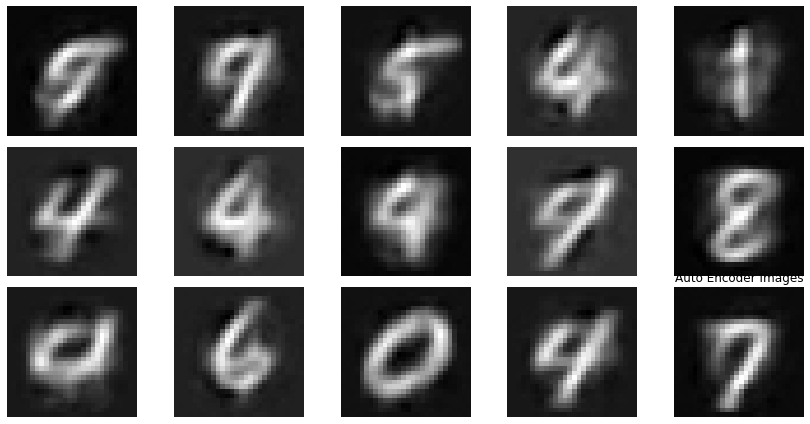

In [6]:
import matplotlib.pyplot as plt

z = np.random.normal(0, 1, (15, z_dim))
decoded_images = decoder.predict(z) * 255

fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Auto Encoder Images')
plt.show()